Chapter 3: Improving the Way Neural Networks Learn
--------------------------------------------------

Notebook to accompany lecture on Chapter 3 of Michael Nielsen's online Open Source book 
["Neural Networks and Deep Learning"](http://neuralnetworksanddeeplearning.com/chap3.html)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import *
from matplotlib import *
%matplotlib inline

Chapter 3 covers several topics:

- Better choice of cost function, cross-entropy.  We will also examine some alternative activation functions,
the softmax and ReLU (rectified linear unit).
- Regularization methods.  The text looks at L1, L2, dropout and artificial expansion.  We will also need to
talk more about data whitening and a new method known as batch normalization, which fall under types of 
regularization for improving network learning.
- Look at better methods for initializing the weights in a network.
- And finally this chapter surveys a set of heuristics to help in choosing good hyper parameters for network
learning.  We will update this list.

**Note:** In addition to the discussion in chapter 3, we will be expanding our discussion about best practices
for neural networks with a few other sources as well.  You should look at this youtube video tutorial/review of best practices:

https://www.youtube.com/watch?v=vq2nnJ4g6N0


And in addition I will be referring to the notes and hopefully videos if they put them back up from the Stanford
deep learning course they have been running:

http://cs231n.stanford.edu/syllabus.html

https://www.youtube.com/playlist?list=PLLvH2FwAQhnpj1WEB-jHmPuUeQ8mX-XXG (link to removed lecture videos)

In particular, the Neural Network notes 1-3 have a lot of good summary of best practices for Neural networks, and
the notes about linear classification and optimization before that would be a good review of some of the topics
we have covered in the course so far.

Cross-Entropy Cost Function
----------------------------

Usually we learn most quickly when we are decisively wrong.  Large, impressive and very noticable gains in performace usually
occur when we first begin learning a topic.  Incremental improvements and slower learning gains (in an absolute sense) are
typical of an expert working on improving their performance.

Ideally we would hope that your neural networks would learn fast from their errors, and would show the fastest improvement when
they are decidedly wrong.  However, in practice, this is not the case with the neural networks we have looked at to this point.
For example, we have seen instances in our neural network training and learning where performance seems to stay steady at
some non-optimal point for a long period, before suddenly finding a better solution and jumping to an area of much better
performance.  In our textbook, this is illustrated with the simplest of learning examples for a neural network.
Here we create a network of one unit, with one weight and one bias.  The task is to train the unit to output a 0 whenever
it sees an input of 1.  We can use our previous Network class code to accomplish this:

In [2]:
"""
network.py
~~~~~~~~~~

A module to implement the stochastic gradient descent learning
algorithm for a feedforward neural network.  Gradients are calculated
using backpropagation.  Note that I have focused on making the code
simple, easily readable, and easily modifiable.  It is not optimized,
and omits many desirable features.
"""

#### Libraries
# Standard library
import random

# Third-party libraries
import numpy as np

class Network():

    def __init__(self, sizes):
        """The list ``sizes`` contains the number of neurons in the
        respective layers of the network.  For example, if the list
        was [2, 3, 1] then it would be a three-layer network, with the
        first layer containing 2 neurons, the second layer 3 neurons,
        and the third layer 1 neuron.  The biases and weights for the
        network are initialized randomly, using a Gaussian
        distribution with mean 0, and variance 1.  Note that the first
        layer is assumed to be an input layer, and by convention we
        won't set any biases for those neurons, since biases are only
        ever used in computing the outputs from later layers."""
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x) 
                        for x, y in zip(sizes[:-1], sizes[1:])]

    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""
        for b, w in zip(self.biases, self.weights):
            a = sigmoid_vec(np.dot(w, a)+b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta,
            test_data=None):
        """Train the neural network using mini-batch stochastic
        gradient descent.  The ``training_data`` is a list of tuples
        ``(x, y)`` representing the training inputs and the desired
        outputs.  The other non-optional parameters are
        self-explanatory.  If ``test_data`` is provided then the
        network will be evaluated against the test data after each
        epoch, and partial progress printed out.  This is useful for
        tracking progress, but slows things down substantially."""
        cost = []
        if test_data:
            n_test = len(test_data)
            cost = np.zeros(epochs)
        n = len(training_data)
        for j in xrange(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in xrange(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            if test_data:
                err = self.evaluate_quadratic_cost(test_data)
                print "Epoch {0}: {1} ".format(j, err)
                cost[j] = err
            else:
                print "Epoch {0} complete".format(j)
        return cost
    
    def update_mini_batch(self, mini_batch, eta):
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
        is the learning rate."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [w-(eta/len(mini_batch))*nw 
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb 
                       for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid_vec(z)
            activations.append(activation)
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * \
            sigmoid_prime_vec(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book.  Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in xrange(2, self.num_layers):
            z = zs[-l]
            spv = sigmoid_prime_vec(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * spv
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

    def evaluate(self, test_data):
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""
        test_results = [(np.argmax(self.feedforward(x)), y) 
                        for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)
    
    def evaluate_quadratic_cost(self, test_data):
        test_results = [(self.feedforward(x), y) for (x, y) in test_data]
        return sum( [np.sqrt((x - y)**2.0) for (x, y) in test_results]  )    
        
    def cost_derivative(self, output_activations, y):
        """Return the vector of partial derivatives \partial C_x /
        \partial a for the output activations."""
        return (output_activations-y) 

#### Miscellaneous functions
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

sigmoid_vec = np.vectorize(sigmoid)

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

sigmoid_prime_vec = np.vectorize(sigmoid_prime)

In [3]:
# use same initial weights and biases, and use same meta-parameters from ch03 example
net = Network( (1, 1) )
net.weights[0][0] = 2.0
net.biases[0][0] = 2.0
print net.weights, net.biases
print net.feedforward(np.array([1.0]))



[array([[ 2.]])] [array([[ 2.]])]
[[ 0.98201379]]


In [4]:
epochs = 300
mini_batch_size = 1
learning_rate = 0.15

training_data = [ (np.array([1.0]), np.array([0.0])) ]
test_data = [ (np.array([1.0]), np.array([0.0])) ]

cost = net.SGD(training_data, epochs, mini_batch_size, learning_rate, test_data=test_data)

Epoch 0: 0.981921651143 
Epoch 1: 0.981828590913 
Epoch 2: 0.981734595742 
Epoch 3: 0.981639651761 
Epoch 4: 0.981543744831 
Epoch 5: 0.981446860533 
Epoch 6: 0.981348984164 
Epoch 7: 0.981250100731 
Epoch 8: 0.981150194941 
Epoch 9: 0.981049251196 
Epoch 10: 0.980947253583 
Epoch 11: 0.98084418587 
Epoch 12: 0.980740031494 
Epoch 13: 0.980634773554 
Epoch 14: 0.980528394806 
Epoch 15: 0.980420877646 
Epoch 16: 0.980312204112 
Epoch 17: 0.980202355863 
Epoch 18: 0.98009131418 
Epoch 19: 0.979979059949 
Epoch 20: 0.979865573652 
Epoch 21: 0.97975083536 
Epoch 22: 0.979634824719 
Epoch 23: 0.979517520939 
Epoch 24: 0.979398902783 
Epoch 25: 0.979278948557 
Epoch 26: 0.979157636093 
Epoch 27: 0.979034942742 
Epoch 28: 0.978910845358 
Epoch 29: 0.978785320282 
Epoch 30: 0.978658343335 
Epoch 31: 0.978529889797 
Epoch 32: 0.978399934396 
Epoch 33: 0.978268451289 
Epoch 34: 0.978135414052 
Epoch 35: 0.978000795659 
Epoch 36: 0.977864568466 
Epoch 37: 0.977726704194 
Epoch 38: 0.977587173913 

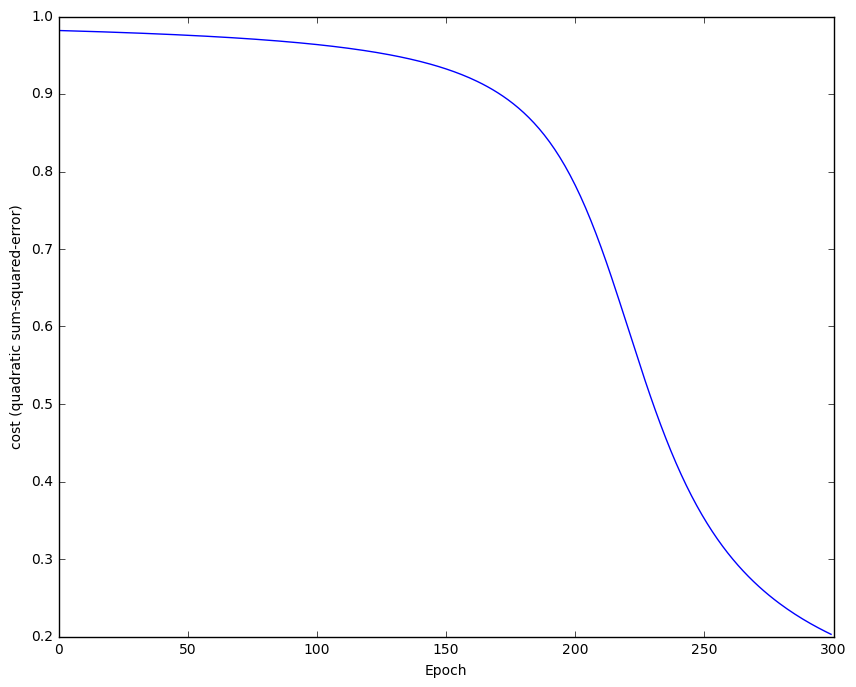

In [5]:
plt.figure(figsize=(10,8))
plt.plot(range(300), cost)
plt.xlabel('Epoch')
plt.ylabel('cost (quadratic sum-squared-error)')

We can see that learning starts out slow, and doesn't speed up until after epoch 150.  This behavior is strange when compared
to human learning, where we expect fastest learning gains when we are most wrong.  Why is learning slow here with our
neural networks, and can we find a way of avoiding this slowdown?

In a nutshell, the rate of change of our weights for sigmoidal units depends on the derivative (the rate of change) of
the sigmoid function.  Recall that the sigmoid functions is basically flat for values far from zero, and is steepest
for the value at 0.  

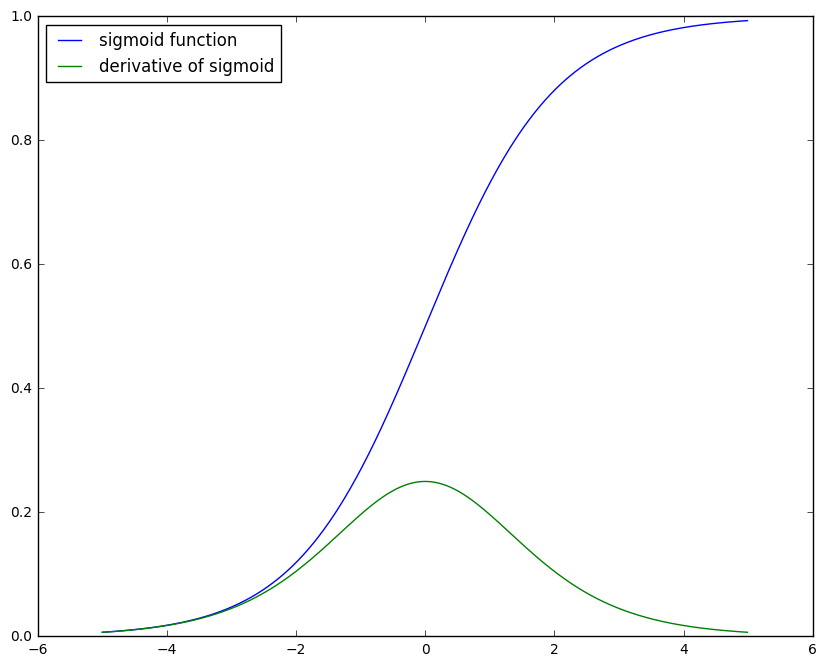

In [6]:
x = np.arange(-5, 5, 0.01)
y = sigmoid(x)
plt.figure(figsize=(10, 8))
plt.plot(x, y, label='sigmoid function')
y = sigmoid_prime(x)
plt.plot(x, y, label='derivative of sigmoid')
plt.legend(loc=0)

This means that, when our weights and biases are such that they give very small or large values, the
neuron output has become saturated.  When the neuron output is saturated, the rate of change of the sigmoid function
becomes close to 0.  In our neural networks using gradient descent, we have been using the quadratic cost function
(the sum squared error) so far.  However, the quadratic cost function depends on the derivative of the sigmoid function
to determine the amount of change it makes when updating the weights and biases.  Thus when the output of the
neuron is saturated, the weights and biases change slowly, the opposite of what we would like to happen.

Introducing the Cross-Entropy Cost Function
-------------------------------------------

How can we address this learning slowdown?  In short, we can use alternative cost functions for our gradient descent learning, ones
that avoid using the derivative of the sigmoid function, and thus potentially will change fast when the neuron is saturated.
We define the cross-entropy cost function for a neuron like this:

$$
C = - \frac{1}{n} \sum_x [y \; \mathrm{ln} \; a + (1 - y) \; \mathrm{ln} \; (1 - a)]
$$

where $n$ is the total number of items of training data, the sum is over all training inputs, $x$ and $y$ is the corresponding
desired output.

Though it is not obvious from inspecting this function, we can show that it works as a perfectly good cost estimate.  First of all
the function is non-negative, $C > 0$ always.  Secondly, if the neuron's actual output is close to the desired output, then
the cross-entropy function will be close to zero.

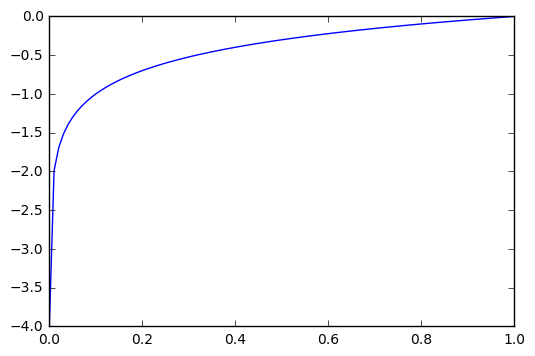

In [7]:
# sigmoid activation functions gives value in range 0 to 1 as output (see previous figure)
# the natural log function of values between 0 and 1 is negative
x = np.linspace(0.0001, 1, 100)
plt.figure()
plt.plot(x, np.log10(x))


In [8]:
def cross_entropy_cost(a, y):
    n = 1.0 # we are assuming we are calculating cost for a single activation/output
    return - (1.0 / n) * ( (y * np.log(a)) + ((1-y) * np.log(1 - a)) )

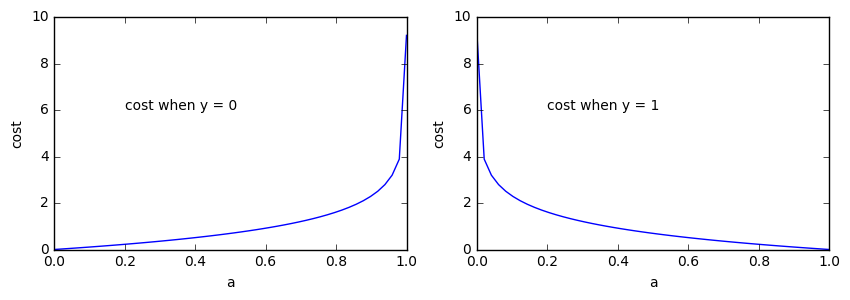

In [9]:
# and we have seen before, for classification problems where the desired output is always 0 or 1, we have
plt.figure(figsize=(10,3))

# case where y = 0
a = np.linspace(0.0001, 0.9999, 50)
y = np.zeros(a.shape)

plt.subplot(1,2,1)
plt.plot(a, cross_entropy_cost(a, y))
plt.xlabel('a')
plt.ylabel('cost')
plt.text(0.2, 6, 'cost when y = 0')

# case where y = 1
y = np.ones(a.shape)

plt.subplot(1,2,2)
plt.plot(a, cross_entropy_cost(a, y))
plt.xlabel('a')
plt.ylabel('cost')
plt.text(0.2, 6, 'cost when y = 1')

Lets return to the previous example and see what happens when we use the cross-entropy cost function instead of the
quadratic cost.  The following code adds in the ability to use cross-entropy or the quadratic cost function as desired to
our Network class

In [10]:
"""network2.py
~~~~~~~~~~~~~~

An improved version of network.py, implementing the stochastic
gradient descent learning algorithm for a feedforward neural network.
Improvements include the addition of the cross-entropy cost function,
regularization, and better initialization of network weights.  Note
that I have focused on making the code simple, easily readable, and
easily modifiable.  It is not optimized, and omits many desirable
features.

"""

#### Libraries
# Standard library
import json
import random
import sys

# Third-party libraries
import numpy as np


#### Define the quadratic and cross-entropy cost functions

class QuadraticCost:

    @staticmethod
    def fn(a, y):
        """Return the cost associated with an output ``a`` and desired output
        ``y``.

        """
        return 0.5*np.linalg.norm(a-y)**2

    @staticmethod
    def delta(z, a, y):
        """Return the error delta from the output layer."""
        return (a-y) * sigmoid_prime_vec(z)


class CrossEntropyCost:

    @staticmethod
    def fn(a, y):
        """Return the cost associated with an output ``a`` and desired output
        ``y``.  Note that np.nan_to_num is used to ensure numerical
        stability.  In particular, if both ``a`` and ``y`` have a 1.0
        in the same slot, then the expression (1-y)*np.log(1-a)
        returns nan.  The np.nan_to_num ensures that that is converted
        to the correct value (0.0).

        """
        return np.nan_to_num(np.sum(-y*np.log(a)-(1-y)*np.log(1-a)))

    @staticmethod
    def delta(z, a, y):
        """Return the error delta from the output layer.  Note that the
        parameter ``z`` is not used by the method.  It is included in
        the method's parameters in order to make the interface
        consistent with the delta method for other cost classes.

        """
        return (a-y)


#### Main Network class
class Network():

    def __init__(self, sizes, cost=CrossEntropyCost):
        """The list ``sizes`` contains the number of neurons in the respective
        layers of the network.  For example, if the list was [2, 3, 1]
        then it would be a three-layer network, with the first layer
        containing 2 neurons, the second layer 3 neurons, and the
        third layer 1 neuron.  The biases and weights for the network
        are initialized randomly, using
        ``self.default_weight_initializer`` (see docstring for that
        method).

        """
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.default_weight_initializer()
        self.cost=cost

    def default_weight_initializer(self):
        """Initialize each weight using a Gaussian distribution with mean 0
        and standard deviation 1 over the square root of the number of
        weights connecting to the same neuron.  Initialize the biases
        using a Gaussian distribution with mean 0 and standard
        deviation 1.

        Note that the first layer is assumed to be an input layer, and
        by convention we won't set any biases for those neurons, since
        biases are only ever used in computing the outputs from later
        layers.

        """
        self.biases = [np.random.randn(y, 1) for y in self.sizes[1:]]
        self.weights = [np.random.randn(y, x)/np.sqrt(x) 
                        for x, y in zip(self.sizes[:-1], self.sizes[1:])]

    def large_weight_initializer(self):
        """Initialize the weights using a Gaussian distribution with mean 0
        and standard deviation 1.  Initialize the biases using a
        Gaussian distribution with mean 0 and standard deviation 1.

        Note that the first layer is assumed to be an input layer, and
        by convention we won't set any biases for those neurons, since
        biases are only ever used in computing the outputs from later
        layers.

        This weight and bias initializer uses the same approach as in
        Chapter 1, and is included for purposes of comparison.  It
        will usually be better to use the default weight initializer
        instead.

        """
        self.biases = [np.random.randn(y, 1) for y in self.sizes[1:]]
        self.weights = [np.random.randn(y, x) 
                        for x, y in zip(self.sizes[:-1], self.sizes[1:])]

    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""
        for b, w in zip(self.biases, self.weights):
            a = sigmoid_vec(np.dot(w, a)+b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta, 
            lmbda = 0.0, 
            evaluation_data=None, 
            monitor_evaluation_cost=False,
            monitor_evaluation_accuracy=False,
            monitor_training_cost=False, 
            monitor_training_accuracy=False):
        """Train the neural network using mini-batch stochastic gradient
        descent.  The ``training_data`` is a list of tuples ``(x, y)``
        representing the training inputs and the desired outputs.  The
        other non-optional parameters are self-explanatory, as is the
        regularization parameter ``lmbda``.  The method also accepts
        ``evaluation_data``, usually either the validation or test
        data.  We can monitor the cost and accuracy on either the
        evaluation data or the training data, by setting the
        appropriate flags.  The method returns a tuple containing four
        lists: the (per-epoch) costs on the evaluation data, the
        accuracies on the evaluation data, the costs on the training
        data, and the accuracies on the training data.  All values are
        evaluated at the end of each training epoch.  So, for example,
        if we train for 30 epochs, then the first element of the tuple
        will be a 30-element list containing the cost on the
        evaluation data at the end of each epoch. Note that the lists
        are empty if the corresponding flag is not set.

        """
        if evaluation_data: n_data = len(evaluation_data)
        n = len(training_data)
        evaluation_cost, evaluation_accuracy = [], []
        training_cost, training_accuracy = [], []
        for j in xrange(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in xrange(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(
                    mini_batch, eta, lmbda, len(training_data))
            print "Epoch %s training complete" % j
            if monitor_training_cost:
                cost = self.total_cost(training_data, lmbda)
                training_cost.append(cost)
                print "Cost on training data: {}".format(cost)
            if monitor_training_accuracy:
                accuracy = self.accuracy(training_data, convert=True)
                training_accuracy.append(accuracy)
                print "Accuracy on training data: {} / {}".format(
                    accuracy, n)
            if monitor_evaluation_cost:
                cost = self.total_cost(evaluation_data, lmbda, convert=True)
                evaluation_cost.append(cost)
                print "Cost on evaluation data: {}".format(cost)
            if monitor_evaluation_accuracy:
                accuracy = self.accuracy(evaluation_data)
                evaluation_accuracy.append(accuracy)
                print "Accuracy on evaluation data: {} / {}".format(
                    self.accuracy(evaluation_data), n_data)
            print
        return evaluation_cost, evaluation_accuracy, \
            training_cost, training_accuracy

    def update_mini_batch(self, mini_batch, eta, lmbda, n):
        """Update the network's weights and biases by applying gradient
        descent using backpropagation to a single mini batch.  The
        ``mini_batch`` is a list of tuples ``(x, y)``, ``eta`` is the
        learning rate, ``lmbda`` is the regularization parameter, and
        ``n`` is the total size of the training data set.

        """
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [(1-eta*(lmbda/n))*w-(eta/len(mini_batch))*nw 
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb 
                       for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid_vec(z)
            activations.append(activation)
        # backward pass
        delta = (self.cost).delta(zs[-1], activations[-1], y)
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book.  Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in xrange(2, self.num_layers):
            z = zs[-l]
            spv = sigmoid_prime_vec(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * spv
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

    def accuracy(self, data, convert=False):
        """Return the number of inputs in ``data`` for which the neural
        network outputs the correct result. The neural network's
        output is assumed to be the index of whichever neuron in the
        final layer has the highest activation.  

        The flag ``convert`` should be set to False if the data set is
        validation or test data (the usual case), and to True if the
        data set is the training data. The need for this flag arises
        due to differences in the way the results ``y`` are
        represented in the different data sets.  In particular, it
        flags whether we need to convert between the different
        representations.  It may seem strange to use different
        representations for the different data sets.  Why not use the
        same representation for all three data sets?  It's done for
        efficiency reasons -- the program usually evaluates the cost
        on the training data and the accuracy on other data sets.
        These are different types of computations, and using different
        representations speeds things up.  More details on the
        representations can be found in
        mnist_loader.load_data_wrapper.

        """
        if convert:
            results = [(np.argmax(self.feedforward(x)), np.argmax(y)) 
                       for (x, y) in data]
        else:
            results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in data]
        return sum(int(x == y) for (x, y) in results)

    def total_cost(self, data, lmbda, convert=False):
        """Return the total cost for the data set ``data``.  The flag
        ``convert`` should be set to False if the data set is the
        training data (the usual case), and to True if the data set is
        the validation or test data.  See comments on the similar (but
        reversed) convention for the ``accuracy`` method, above.
        """
        cost = 0.0
        for x, y in data:
            a = self.feedforward(x)
            if convert: y = vectorized_result(y)
            cost += self.cost.fn(a, y)/len(data)
        cost += 0.5*(lmbda/len(data))*sum(
            np.linalg.norm(w)**2 for w in self.weights)
        return cost

    def save(self, filename):
        """Save the neural network to the file ``filename``."""
        data = {"sizes": self.sizes,
                "weights": [w.tolist() for w in self.weights],
                "biases": [b.tolist() for b in self.biases],
                "cost": str(self.cost.__name__)}
        f = open(filename, "w")
        json.dump(data, f)
        f.close()

#### Loading a Network
def load(filename):
    """Load a neural network from the file ``filename``.  Returns an
    instance of Network.

    """
    f = open(filename, "r")
    data = json.load(f)
    f.close()
    cost = getattr(sys.modules[__name__], data["cost"])
    net = Network(data["sizes"], cost=cost)
    net.weights = [np.array(w) for w in data["weights"]]
    net.biases = [np.array(b) for b in data["biases"]]
    return net

#### Miscellaneous functions
def vectorized_result(j):
    """Return a 10-dimensional unit vector with a 1.0 in the j'th position
    and zeroes elsewhere.  This is used to convert a digit (0...9)
    into a corresponding desired output from the neural network.

    """
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

sigmoid_vec = np.vectorize(sigmoid)

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

sigmoid_prime_vec = np.vectorize(sigmoid_prime)

In [11]:
# use same initial weights and biases, and use same meta-parameters from ch03 example
net = Network( (1, 1) )
net.weights[0][0] = 5.0
net.biases[0][0] = 5.0
print net.weights, net.biases
print net.feedforward(np.array([1.0]))

[array([[ 5.]])] [array([[ 5.]])]
[[ 0.9999546]]


In [12]:
epochs = 300
mini_batch_size = 1
learning_rate = 0.15

training_data = [ (np.array([1.0]), np.array([0.0])) ]
test_data = [ (np.array([1.0]), np.array([0.0])) ]

eval_cost, eval_acc, train_cost, train_acc = net.SGD(training_data, epochs, mini_batch_size, learning_rate, evaluation_data=test_data, monitor_training_cost=True)

Epoch 0 training complete
Cost on training data: 9.70007490014

Epoch 1 training complete
Cost on training data: 9.40011472103

Epoch 2 training complete
Cost on training data: 9.10016847064

Epoch 3 training complete
Cost on training data: 8.80024101961

Epoch 4 training complete
Cost on training data: 8.50033894063

Epoch 5 training complete
Cost on training data: 8.20047110225

Epoch 6 training complete
Cost on training data: 7.9006494691

Epoch 7 training complete
Cost on training data: 7.60089017965

Epoch 8 training complete
Cost on training data: 7.30121499653

Epoch 9 training complete
Cost on training data: 7.00165325614

Epoch 10 training complete
Cost on training data: 6.70224448558

Epoch 11 training complete
Cost on training data: 6.4030419084

Epoch 12 training complete
Cost on training data: 6.10411712827

Epoch 13 training complete
Cost on training data: 5.80556636369

Epoch 14 training complete
Cost on training data: 5.50751870586

Epoch 15 training complete
Cost on tr

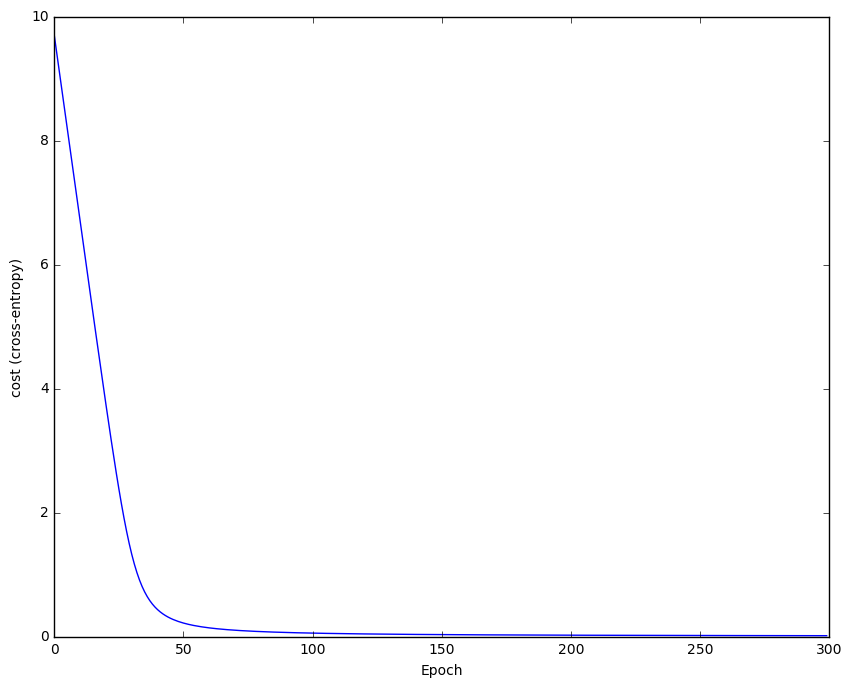

In [13]:
plt.figure(figsize=(10,8))
plt.plot(range(300), train_cost)
plt.xlabel('Epoch')
plt.ylabel('cost (cross-entropy)')

Overfitting and Regularization
------------------------------

Models with a large number of free parameters can potentially fit exactly even large data sets, and neural networks usually
have a huge number of free parameters (each weight and bias represents a potentially tunable free parameter).  So overfitting
can potentially be a big problem when using neural networks.  But an overfitted model, that agrees (amazingly) well with
the data it was trained on is not necessarily a good model.  The true test of a model is how well it does at predicting
unseen/new data points, in situations it has not been trained on before.

We can construct a situation where our neural network does a bad job of generalizing to new situations.  Having less data
to train with makes it more likely that the network will overfit on the available data.  Thus, for the MNIST database, we can
instead use only the first 1,000 training images.  Using that restricted set will make the problem with generalization
much more evident.  

We train using the cross-entropy cost function, with a learning rate of $\eta = 0.5$ and a mini-batch size of 10, and we will
train for 400 epochs.  We have moved the current version of the network code and the loader code into script files, so that
we can import them.

In [14]:
import sys
sys.path.append('scripts')
print sys.path

['', '/home/dharter/anaconda2/lib/python27.zip', '/home/dharter/anaconda2/lib/python2.7', '/home/dharter/anaconda2/lib/python2.7/plat-linux2', '/home/dharter/anaconda2/lib/python2.7/lib-tk', '/home/dharter/anaconda2/lib/python2.7/lib-old', '/home/dharter/anaconda2/lib/python2.7/lib-dynload', '/home/dharter/anaconda2/lib/python2.7/site-packages', '/home/dharter/anaconda2/lib/python2.7/site-packages/Sphinx-1.5.1-py2.7.egg', '/home/dharter/anaconda2/lib/python2.7/site-packages/setuptools-27.2.0-py2.7.egg', '/home/dharter/anaconda2/lib/python2.7/site-packages/IPython/extensions', '/home/dharter/.ipython', 'scripts']


In [15]:
import mnist_loader
training_data, validation_data, test_data = mnist_loader.load_data_wrapper()

In [16]:
import network2
net = network2.Network([784, 30, 10], cost=network2.CrossEntropyCost)
net.large_weight_initializer()
eval_cost, eval_acc, train_cost, train_acc = \
    net.SGD(training_data[:1000], 400, 10, 0.5, evaluation_data=test_data, 
            monitor_training_cost=True, monitor_training_accuracy=True,
            monitor_evaluation_cost=True, monitor_evaluation_accuracy=True)

Epoch 0 training complete
Cost on training data: 1.94571726482
Accuracy on training data: 637 / 1000
Cost on evaluation data: 2.31205911198
Accuracy on evaluation data: 5495 / 10000

Epoch 1 training complete
Cost on training data: 1.39794586277
Accuracy on training data: 762 / 1000
Cost on evaluation data: 1.817201638
Accuracy on evaluation data: 6582 / 10000

Epoch 2 training complete
Cost on training data: 1.09443589466
Accuracy on training data: 845 / 1000
Cost on evaluation data: 1.63168934426
Accuracy on evaluation data: 7049 / 10000

Epoch 3 training complete
Cost on training data: 0.909108164021
Accuracy on training data: 879 / 1000
Cost on evaluation data: 1.48826785987
Accuracy on evaluation data: 7339 / 10000

Epoch 4 training complete
Cost on training data: 0.793413607844
Accuracy on training data: 894 / 1000
Cost on evaluation data: 1.40668350619
Accuracy on evaluation data: 7577 / 10000

Epoch 5 training complete
Cost on training data: 0.670361271155
Accuracy on training 

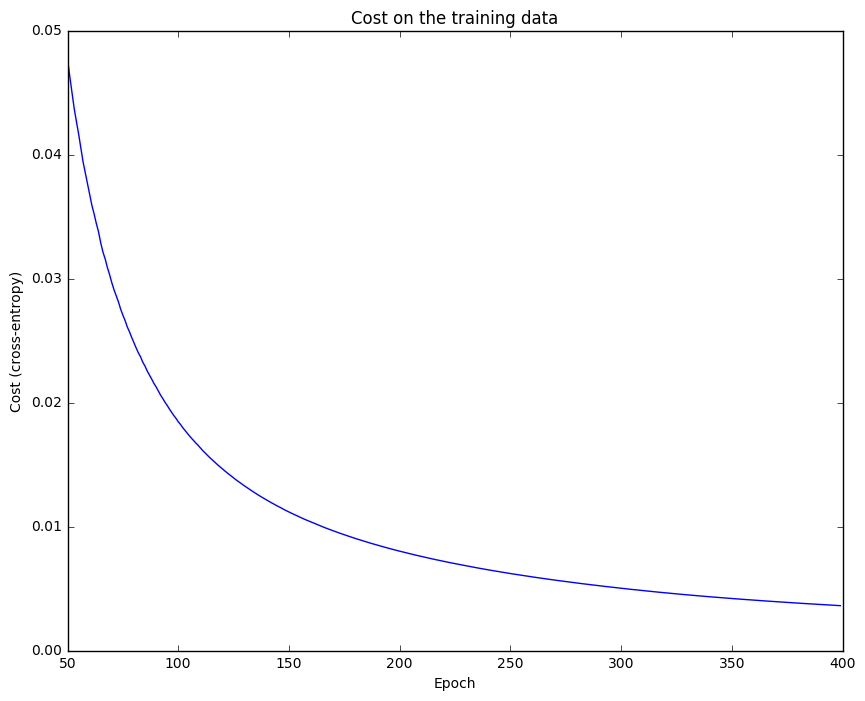

In [17]:
plt.figure(figsize=(10,8))
epochs = np.arange(0, 400)
plt.plot(epochs[50:], train_cost[50:])
plt.title('Cost on the training data')
plt.xlabel('Epoch')
plt.ylabel('Cost (cross-entropy)')

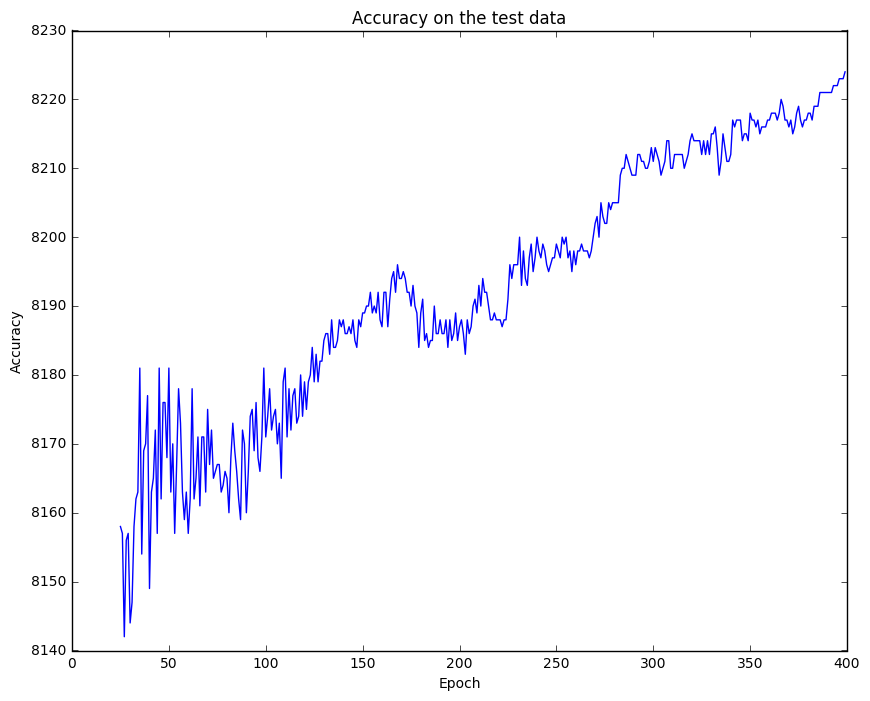

In [18]:
plt.figure(figsize=(10,8))
plt.plot(epochs[25:], eval_acc[25:])
plt.title('Accuracy on the test data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

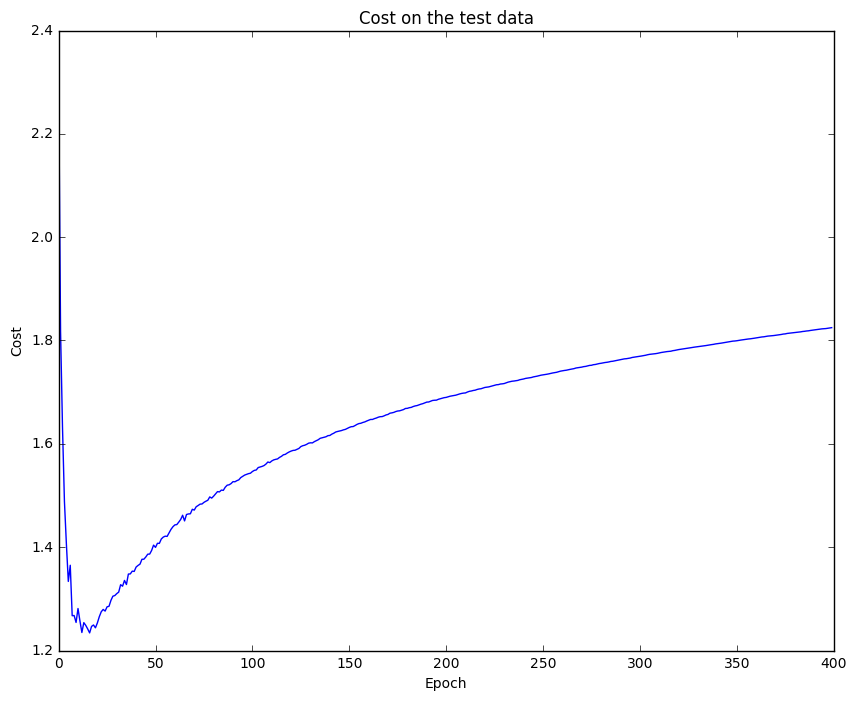

In [19]:
plt.figure(figsize=(10,8))
plt.plot(epochs, eval_cost)
plt.title('Cost on the test data')
plt.xlabel('Epoch')
plt.ylabel('Cost')

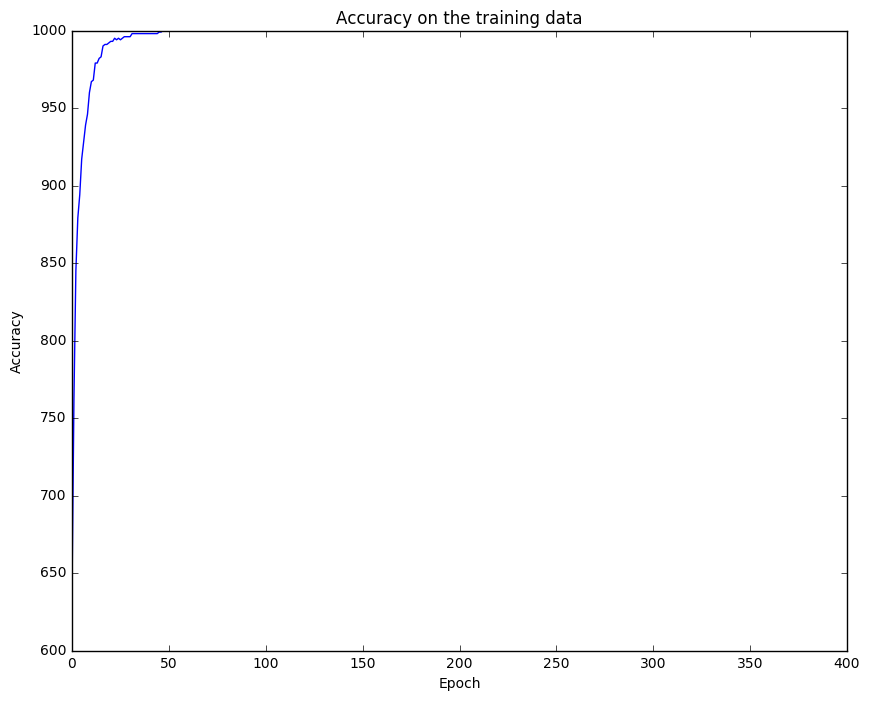

In [20]:
plt.figure(figsize=(10,8))
plt.plot(epochs, train_acc)
plt.title('Accuracy on the training data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

As in the books example, the training cost continues to improve, but accuracy is probably reaching a plateau at 82% in this case
(a bit after epoch 100).  The cost on the test data set is most informative.  We can see that the cost on the test data
improves until maybe epoch 20 or so, and then starts to get worse, even though the cost on the training data is continuing to
improve.  This is clear evidence that overfitting has begin somewhere between epoch 20 and 200.  Another sign is that the classification accuracy on the training data has risen to 100 percent, but our test accuracy is only topping out at 56 percent.
So our network really is learning pecularities of the training data, not just recognizing digits in general.

Overfitting is a major problem in neural networks.  This is especially true in modern networks (on large super computers) that
can contain very large numbers of weights and biases (in the millions or more).  To train effectively we need a way to detect
when overfitting is going on so we don't overtrain.  

The obvious way to detect overfitting is to use the approach above, keep track of accuracy on the test data as we train our
network.  If we see that the accuracy on the test data is no longer improving, then we should stop training.  Of course this is
not necessiarly stricly speaking a sign of overfitting.  It might be that the accuracy on the test data and training data both stop
improving at the same time.  Or the accuracy on the test data can plateu for a bit (though using cross-entropy cost function should
help in this respect).

Here is an example of training with the full data set.  We will compare the accuracy on the test and validation data sets.  We
keep all of the parameters the same as we have been using previously.

In [21]:
net = network2.Network([784, 30, 10], cost=network2.CrossEntropyCost)
net.large_weight_initializer()
eval_cost, eval_acc, train_cost, train_acc = \
    net.SGD(training_data, 30, 10, 0.5, evaluation_data=validation_data, 
            monitor_training_cost=True, monitor_training_accuracy=True,
            monitor_evaluation_cost=True, monitor_evaluation_accuracy=True)

Epoch 0 training complete
Cost on training data: 0.582830674336
Accuracy on training data: 45486 / 50000
Cost on evaluation data: 0.56310525918
Accuracy on evaluation data: 9125 / 10000

Epoch 1 training complete
Cost on training data: 0.464037941534
Accuracy on training data: 46539 / 50000
Cost on evaluation data: 0.480738966555
Accuracy on evaluation data: 9303 / 10000

Epoch 2 training complete
Cost on training data: 0.397189600845
Accuracy on training data: 47005 / 50000
Cost on evaluation data: 0.427238037771
Accuracy on evaluation data: 9342 / 10000

Epoch 3 training complete
Cost on training data: 0.345709917565
Accuracy on training data: 47465 / 50000
Cost on evaluation data: 0.390914958359
Accuracy on evaluation data: 9444 / 10000

Epoch 4 training complete
Cost on training data: 0.337864119106
Accuracy on training data: 47580 / 50000
Cost on evaluation data: 0.392667716493
Accuracy on evaluation data: 9432 / 10000

Epoch 5 training complete
Cost on training data: 0.3070227232

As you can see, the accuracy on the test and training data remain much closer togetehr than when we were using 1,000
training examples.  In particular, the best classification accuracy of about 97.5 percent on the training data is only about
2.0 percent higher than the best for the validation/test data.  Overfitting has been greatly reduced.  In general, one of
the best ways to reduce overfitting is to increase the size of the training data, if you can do it.  Unfortunately training
data can be expensive or difficult to acquire, so this is not always practical.

In [22]:
test_pct = [correct / 10000.0 for correct in eval_acc]
train_pct = [correct / 50000.0 for correct in train_acc]

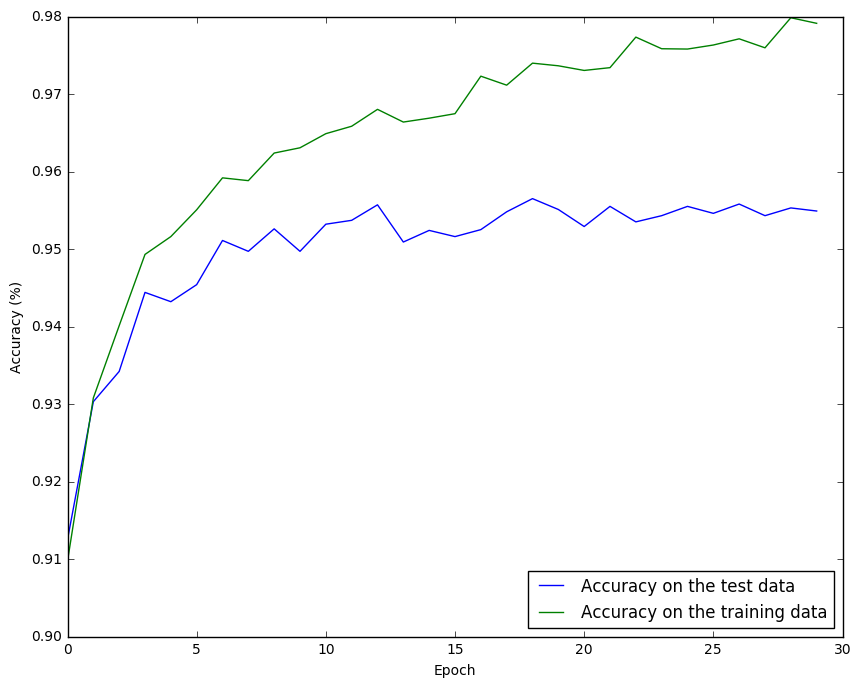

In [23]:
plt.figure(figsize=(10,8))
epochs = np.arange(0, 30)
plt.plot(epochs, test_pct, label='Accuracy on the test data')
plt.plot(epochs, train_pct, label='Accuracy on the training data')
plt.xlabel('Epoch')
plt.legend(loc=4)
plt.ylabel('Accuracy (%)')

Regularization
--------------

Increasing the amount of training data is one way of reducing overfitting.  Are there other ways?  One possible approach
is to reduce the size of our network.  However, bigger networks are more powerful, so we don't normally want to adopt this
approach.

There are other techniques which can reduce overfitting.  These are known as regularization techniques.  In general, most
regularization techniques involve limiting or scaling the network weights, in such a manner so that they are made smaller
and tend to be pushed back towards 0.  

The L2 technique is the most common regularization technique.  It works by adding a term to the cost function which increases
the cost proporition to the size of the sum of the weights in the network.  The effect of this additional cost term is to
give lower costs (which are favored) to networks with smaller weights (all things being equal, e.g. if two networks give the same
answer, but one does it with smaller weights, it will have a lower cost).

For example, here is the cross-entropy cost function with an added regularization term.  The extra term (the sum of the square of
the weights on the end) will be bigger when the weights are large, and will be smaller when the weights are small (where $x$ are all
the training inputs, we have $j$ output units, and $y_j$ is the expected output and $a_j^L$ is the actual output):

$$
C = - \frac{1}{n} \sum_{xj} \big[ y_j \; \mathrm{ln} \; a_j^L + (1 - y_j) \; \mathrm{ln} (1 - a_j^L) \big] + \frac{\lambda}{2n} \sum_w w^2
$$

The sum of the squares of all of the weights is scaled by a factor $\lambda / 2n$ where $\lambda > 0$ is known as the
*regularization parameter*, and $n$ is the size of our training set as usual.  Notice that the regularization doesn't include
the biases, only the weights. 

Intiutively the effect of regularization is to make it so the network prefers to learn small weights, all other things being
equal.  Large weights will only be allowed if they (considerably) improve the first part of the cost function.  Put another
way, regularization can be viewed as a way of compromising between finding small weights and minimizing the original
cost function.  The relative importance of the two elements of the compromise depends on the value of $\lambda$: when
$\lambda$ is small we prefer to minimize the original cost function, but when $\lambda$ is large we prefer small weights.

Not its not at all obvious why making this kind of compromise should help in reducing overfitting.  But it turns out that it
does.  We'll address the question of why it helps in the next section.  But first let's work through an example showing that
regularization really does reduce overfitting.  We'll use a network with 30 hidden neurons, a mini-batch size of 10,
a learning rate of 0.5, and the cross-entropy cost function.  However, this time we'll use a regularization parameter of 
$\lambda = 0.1$.  Note that in the code, we use the variable name `lmbda` becase `lambda` is a reserved word in Python, with
an unrelated meanting.  We will also use the test_data again, not the validation_data.  



In [24]:
net = network2.Network([784, 30, 10], cost=network2.CrossEntropyCost)
net.large_weight_initializer()
eval_cost, eval_acc, train_cost, train_acc = \
    net.SGD(training_data[:1000], 400, 10, 0.5, 
            evaluation_data=test_data, lmbda=0.1,
            monitor_training_cost=True, monitor_training_accuracy=True,
            monitor_evaluation_cost=True, monitor_evaluation_accuracy=True)

Epoch 0 training complete
Cost on training data: 3.1334024258
Accuracy on training data: 613 / 1000
Cost on evaluation data: 2.29178883981
Accuracy on evaluation data: 5549 / 10000

Epoch 1 training complete
Cost on training data: 2.58636722352
Accuracy on training data: 771 / 1000
Cost on evaluation data: 1.83538545188
Accuracy on evaluation data: 6845 / 10000

Epoch 2 training complete
Cost on training data: 2.2671138903
Accuracy on training data: 840 / 1000
Cost on evaluation data: 1.56206542075
Accuracy on evaluation data: 7485 / 10000

Epoch 3 training complete
Cost on training data: 2.05193231946
Accuracy on training data: 890 / 1000
Cost on evaluation data: 1.44145955157
Accuracy on evaluation data: 7714 / 10000

Epoch 4 training complete
Cost on training data: 1.92515100701
Accuracy on training data: 900 / 1000
Cost on evaluation data: 1.36920681036
Accuracy on evaluation data: 7847 / 10000

Epoch 5 training complete
Cost on training data: 1.82874413684
Accuracy on training dat

The cost on the training data decreases over the whole time, much as it did in the earlier, unregularized case.  But this time
the accuracy on the `validation_data` continues to increase for the entire 400 epochs.

In [25]:
test_pct = [correct / 10000.0 for correct in eval_acc]
train_pct = [correct / 1000.0 for correct in train_acc]

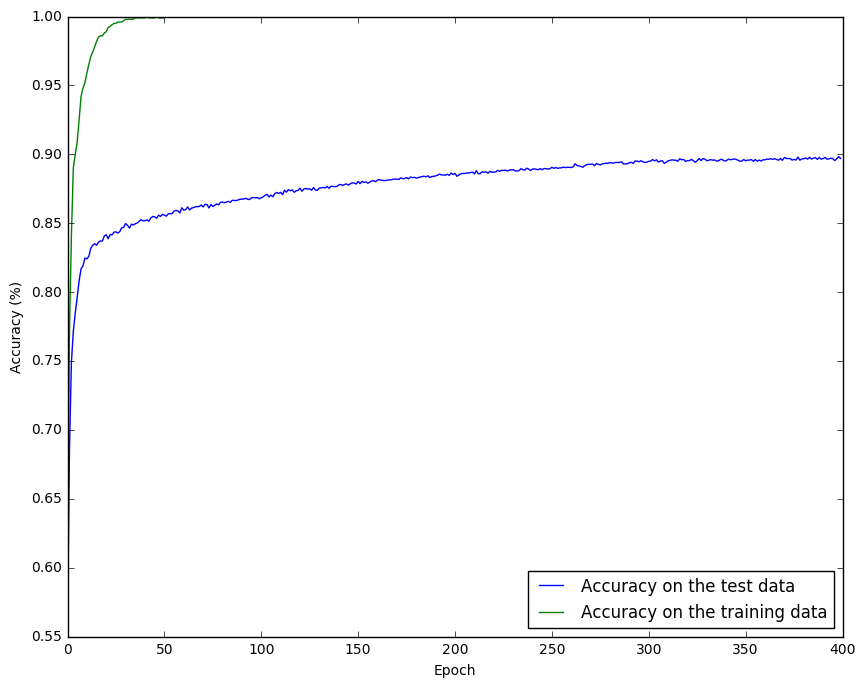

In [26]:
plt.figure(figsize=(10,8))
epochs = np.arange(0, 400)
plt.plot(epochs, test_pct, label='Accuracy on the test data')
plt.plot(epochs, train_pct, label='Accuracy on the training data')
plt.xlabel('Epoch')
plt.legend(loc=4)
plt.ylabel('Accuracy (%)')

Clearly the use of regularization has suppressed overfitting.  What's more, the accuracy is considerably higher, with a peak classification accuracy of 723.8 percent compared to the peak of 55.6 percent obtained in the unregularized case.  And indeed since
the accuracy is still rising on the test data, we should be able to get much more accurate results by continuing to train past
200 epochs.  I seems that empirically, regularization is causing our network to generalize better, and considerably reducing
th eeffects of overfitting.

What happens if we move out of the artifical environment of just having 100 training images and return to the full 50,000 images?
Of course we've seen already that overfitting is much less of a problem with the full set of images.  Does regularization help any
further?  Lets keep the hyper-parameters the same as before - 30 epochs, learning rate 0.5, mini-batch size of 10.  However we
need to modify the regularization parameter.  The reason is because the size of $n$ of the training set has changed from
$n = 100$ to $n = 50000$, and this changes the weight decay factor.  So we compensate by changing $\lambda = 5.0$.

In [27]:
net = network2.Network([784, 30, 10], cost=network2.CrossEntropyCost)
net.large_weight_initializer()
eval_cost, eval_acc, train_cost, train_acc = \
    net.SGD(training_data, 30, 10, 0.5, 
            evaluation_data=test_data, lmbda=5.0,
            monitor_training_cost=True, monitor_training_accuracy=True,
            monitor_evaluation_cost=True, monitor_evaluation_accuracy=True)

Epoch 0 training complete
Cost on training data: 1.28012483055
Accuracy on training data: 46085 / 50000
Cost on evaluation data: 4.31531166838
Accuracy on evaluation data: 9195 / 10000

Epoch 1 training complete
Cost on training data: 0.961101553414
Accuracy on training data: 46642 / 50000
Cost on evaluation data: 2.97452245723
Accuracy on evaluation data: 9293 / 10000

Epoch 2 training complete
Cost on training data: 0.701931034938
Accuracy on training data: 47506 / 50000
Cost on evaluation data: 2.10382680161
Accuracy on evaluation data: 9440 / 10000

Epoch 3 training complete
Cost on training data: 0.567837724023
Accuracy on training data: 47709 / 50000
Cost on evaluation data: 1.61308201963
Accuracy on evaluation data: 9473 / 10000

Epoch 4 training complete
Cost on training data: 0.515632061902
Accuracy on training data: 47726 / 50000
Cost on evaluation data: 1.35769060318
Accuracy on evaluation data: 9457 / 10000

Epoch 5 training complete
Cost on training data: 0.456747571027
Ac

In [28]:
test_pct = [correct / 10000.0 for correct in eval_acc]
train_pct = [correct / 1000.0 for correct in train_acc]

plt.figure(figsize=(10,8))
epochs = np.arange(0, 400)
plt.plot(epochs, test_pct, label='Accuracy on the test data')
plt.plot(epochs, train_pct, label='Accuracy on the training data')
plt.xlabel('Epoch')
plt.legend(loc=4)
plt.ylabel('Accuracy (%)')

There's lots of good news here.  First our classification accuracy on the test data is up, from 95.49 percent when running
unregularized, to 96.49 percent.  Thats a big improvement.  Second, we can see that the gap between results on the training and test
data is much narrower than before, running at under a percent.  That's still a significant gap, but we've obviously made
substantial progress reducing overfitting.

Lets try it with 100 hidden units, to see how far we can push our accuracy.

Why does regularization help reduce overfitting?
--------------------------------------------------

We've shown empirically that regularization helps reduce overfitting.  That's encouraging, but unfortunately, it's not obvious
why regularization helps.  A standard story people tell to explain what's going on is along the following lines: smaller weights
are, in some sense, lower complexity, and so provide a simpler and more powerful explanation for the data, and should thus
be preferred.  That's a pretty terse story, though, and contains several elements that perhaps seem dubious or mystifying. Let's unpack the story and examine it critically.  To do that, let's suppose we have a simple data set for which we wish to build
a model:

''

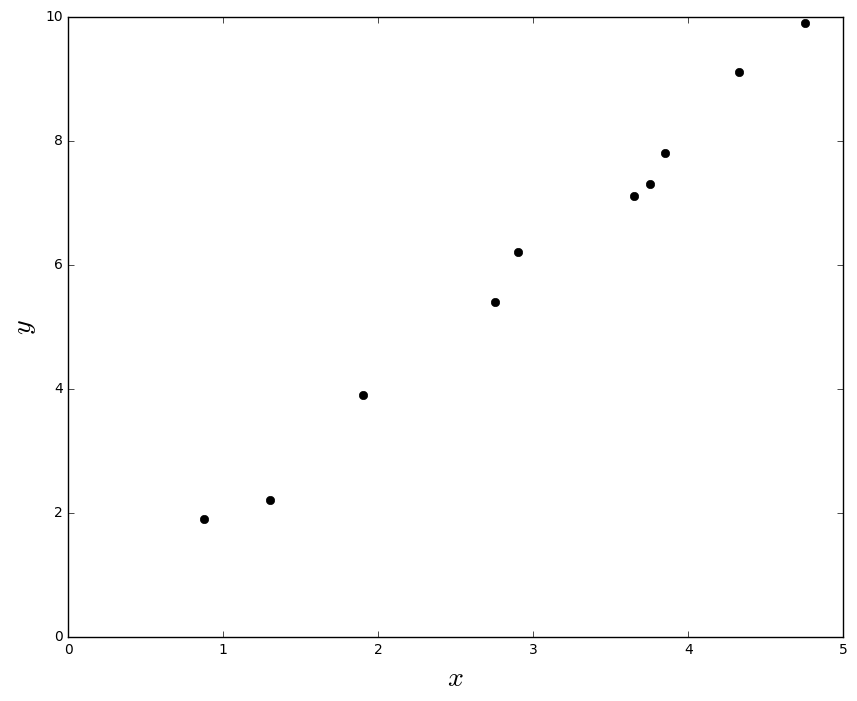

In [29]:
x = np.array([0.875, 1.3, 1.9, 2.75, 2.9, 3.65, 3.75, 3.85, 4.33,  4.75])
y = np.array([1.9,   2.2, 3.9, 5.40, 6.2, 7.10, 7.30, 7.80, 9.10,   9.9])
plt.figure(figsize=(10,8))
plt.plot(x, y, 'ko')
plt.xlabel('$x$', fontsize=20)
plt.ylabel('$y$', fontsize=20)
plt.xlim( (0.0, 5.0) )
plt.ylim( (0.0, 10.0) )
''

Implicitly, we're studying some real-world phenomenon here, with $x$ and $y$ representing real-world data.  Our goal is to build
a model which lets us predict $y$ as a function of $x$.  We could try using neural networks to build such a model, but we're
going to do something even simpler: We'll try to model $y$ as a polynomial in $x$.  We're doing this instead of using neural
nets because using polynomials will make things particularly transparent.  Once we've understood the polynomial case, we'll
translate to neural networks.  Now, there are 10 points in the graph above, which means we can find a unique 9th-order
polynomial $y = a_0x^9 + a_1x^8 + ... + a_9 which fits the data exactly (is guaranteed to go through every point).  Here's how
we find such a polynomial in Python using the `polyfit` function, and the graph of the result:


''

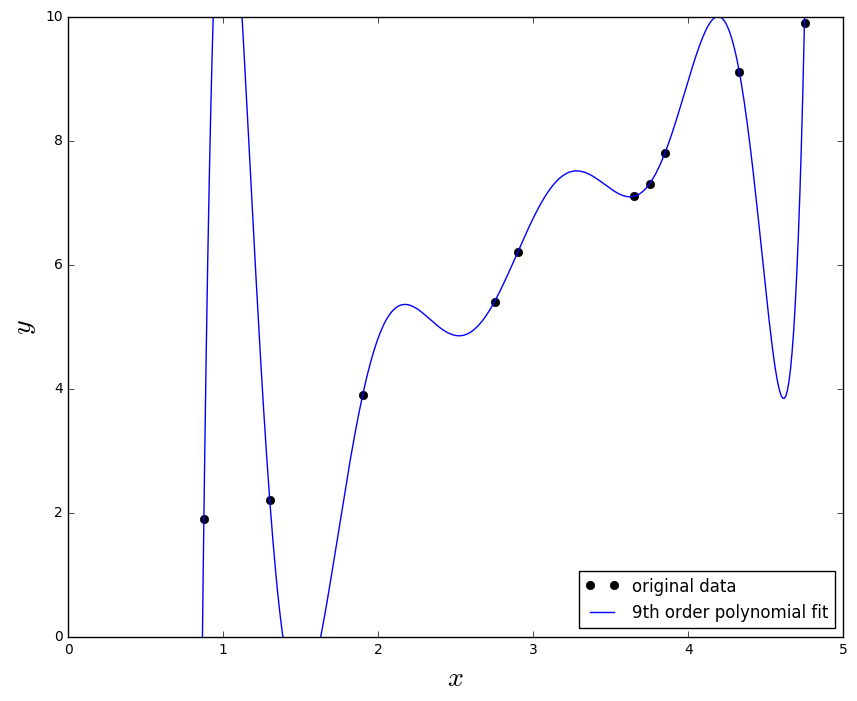

In [30]:
z = np.polyfit(x, y, 9) # finds the coefficients a_0, a_1, ... a_9
f = np.poly1d(z) # returns a function object, given x values, calculates f(x)
x_fit = np.arange(0.8, 4.8, 0.01)
y_fit = f(x_fit)

plt.figure(figsize=(10,8))
plt.plot(x, y, 'ko', label='original data')
plt.plot(x_fit, y_fit, 'b-', label='9th order polynomial fit')
plt.xlabel('$x$', fontsize=20)
plt.ylabel('$y$', fontsize=20)
plt.legend(loc=4)
plt.xlim( (0.0, 5.0) )
plt.ylim( (0.0, 10.0) )
''

This provides an exact fit.  But we can also get a good fit using a linear model (close to $y = 2x$:

[ 2.08686406 -0.19206994]


''

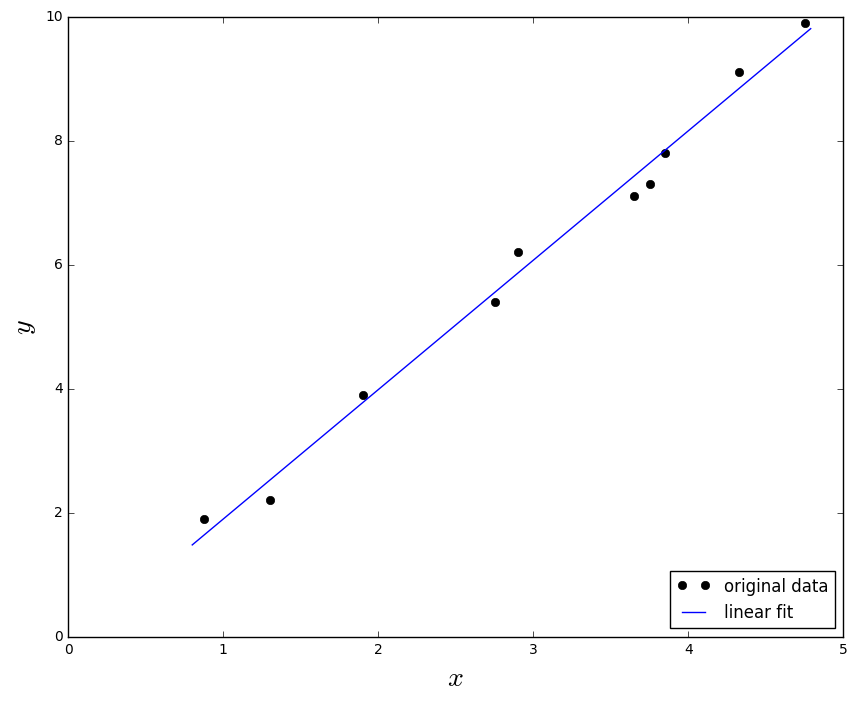

In [31]:
z = np.polyfit(x, y, 1) # finds the coefficients a_0, for a linear model
print z
f = np.poly1d(z) # returns a function object, given x values, calculates f(x)
x_fit = np.arange(0.8, 4.8, 0.01)
y_fit = f(x_fit)

plt.figure(figsize=(10,8))
plt.plot(x, y, 'ko', label='original data')
plt.plot(x_fit, y_fit, 'b-', label='linear fit')
plt.xlabel('$x$', fontsize=20)
plt.ylabel('$y$', fontsize=20)
plt.legend(loc=4)
plt.xlim( (0.0, 5.0) )
plt.ylim( (0.0, 10.0) )
''

Which of these is a better model?  Which is more likely to be true?  And which model is more likely to generalize well to other
examples of the same underlying real-world phenomenon?

These are difficult questions.  In fact, we can't determine with certainty the answer to any of the above questions, without
much more information about the underlying real-world phenomenon.  But let's consider two possibilities: (1) the 9th order
polynomial is, in fact, the model which truly describes the real-world phenomenon, and the model will therefore genrealize
perfectly; (2) the correct model is $y = 2x$, but there's a little additional noise due to, say, measurement error, and that's why
the model isn't an exact fit.

It's not a priori possible to say which of these two possibilities is correct. (Or, indeed, if some third possibility holds). Logically, either could be true. And it's not a trivial difference. It's true that on the data provided there's only a small difference between the two models. But suppose we want to predict the value of y corresponding to some large value of x, much larger than any shown on the graph above. If we try to do that there will be a dramatic difference between the predictions of the two models, as the 9th order polynomial model comes to be dominated by the x9 term, while the linear model remains, well, linear.

One point of view is to say that in science we should go with the simpler explanation, unless compelled not to. When we find 
a simple model that seems to explain many data points we are tempted to shout "Eureka!" After all, it seems unlikely that a 
simple explanation should occur merely by coincidence. Rather, we suspect that the model must be expressing some underlying 
truth about the phenomenon. In the case at hand, the model $y = 2x + \mathrm{noise}$ seems much simpler than 
$y = a_0x^9 + a_1x^8 + ...$. It would be surprising if that simplicity had occurred by chance, and so we suspect 
that $y = 2x + \mathrm{noise}$ expresses some underlying truth. In this point of view, the 9th order model is really just 
learning the effects of local noise. And so while the 9th order model works perfectly for these particular data points, the
model will fail to generalize to other data points, and the noisy linear model will have greater predictive power.

Let's see what this point of view means for neural networks. Suppose our network mostly has small weights, as will tend to 
happen in a regularized network. The smallness of the weights means that the behaviour of the network won't change too much 
if we change a few random inputs here and there. That makes it difficult for a regularized network to learn the effects of 
local noise in the data. Think of it as a way of making it so single pieces of evidence don't matter too much to the output 
of the network. Instead, a regularized network learns to respond to types of evidence which are seen often across the 
training set. By contrast, a network with large weights may change its behaviour quite a bit in response to small changes 
in the input. And so an unregularized network can use large weights to learn a complex model that carries a lot of 
information about the noise in the training data. In a nutshell, regularized networks are constrained to build relatively 
simple models based on patterns seen often in the training data, and are resistant to learning peculiarities of the 
noise in the training data. The hope is that this will force our networks to do real learning about the phenemonon at
hand, and to generalize better from what they learn.

With that said, this idea of preferring simpler explanation should make you nervous. People sometimes refer to this
idea as "Occam's Razor", and will zealously apply it as though it has the status of some general scientific principle
But, of course, it's not a general scientific principle. There is no a priori logical reason to prefer simple 
explanations over more complex explanations. Indeed, sometimes the more complex explanation turns out to be correct.



Other techniques for regularization
-----------------------------------

**L1 regularization**: Instead of adding the square of the weights, we add the sum of the absolute value of the weights:

$$
C = C_0 + \frac{\lambda}{n} \sum_w |w|
$$

This is similar to L2 regularization, penalizing large weights.  Because of this difference, L1 regularization behaves slightly
differently from L2 regularization.  The net result is that L1 regularization tends to concentrate the weight of the network in
a relatively small number of high-importance connections, while other weights are driven towards 0.  Another way of saying this 
is that in L1 regularization, it is more like we are trying to find weights that can be pruned and removed from the network,
and leave only the necessary and important weights remaining.

**Dropout**: Dropout is a radically different technique for regularization.  It doesn't realy on modifying the cost function.
Instead, in dropout we modify the network itself.  Ordinarily we train by forward-propagating values through tne network
then backpropaqgating to determine the contribution to the gradient and modify the weights.  With dropout we start by randomly
(and temporarily) deleting half the hidden neurons in the network.  After doing this we forward propagate and the backpropagate
through this modified network.  By doing this the network still learns a set of weights and biases.  Of course, those
weights and biases will have been learnt under conditions in which half the hidden neurons were dropped out during any
particular batch of learning.  When we dropout different sets of neurons, its like we are training different neural networks 
each time.  So dropout is like averaging the effects of a very large number of different networks.  The effect is usually to
cancel out or minimize learned noise, and thus reduce effects of overfitting.

**Artifically expanding the training data**: We concluded earlier that one ideal way to prevent overfitting is to simply use
more data.  But this approach can be impractical in many situations.  However, in practice, we can often systematically
alter actual training data in subtle ways that will successfully mimic actual noise or variations that we might see if we were
to really gather new and more amounts of real data.  For example, we could rotate our MNIST digit images by a few degrees, giving
slight variations that mimic effect of people writing at different angles.  This idea is powerful and widely used.

Weight Initialization
---------------------

When we create our neural networks, we have to make choices for the initial weights and biases. Just to remind you, that
prescription was to choose both the weights and biases using independent Gaussian random variables, normalized to
have mean 0 and standard deviation 1. While this approach has worked well, it was quite ad hoc, and it's worth revisiting
to see if we can find a better way of setting our initial weights and biases, and perhaps help our neural networks learn faster.

It turns out that we can do quite a bit better than initializing with normalized Gaussians. To see why, suppose we're
working with a network with a large number - say 1,000 - of input neurons. And let's suppose we've used normalized
Gaussians to initialize the weights connecting to the first hidden layer. For now we're going to concentrate specifically
on the weights connecting the input neurons to the first neuron in the hidden layer, and ignore the rest of the network.

We'll suppose for simplicity that we're trying to train using a training input $x$ in which half the input neurons
are on, i.e., set to 1, and half the input neurons are off, i.e., set to 0. The argument which follows applies
more generally, but you'll get the gist from this special case. Let's consider the weighted sum $z = \sum_j w_j x_j + b$
of inputs to our hidden neuron. 500 terms in this sum vanish, because the corresponding input $x_j$ is zero.
And so $z$ is a sum over a total of 501 normalized Gaussian random variables, accounting for the 500 weight terms and 
the 1 extra bias term. Thus $z$ is itself distributed as a Gaussian with mean zero and standard deviation 
$\sqrt{501} \approx 22.4$. That is, $z$ has a very broad Gaussian distribution, not sharply peaked at all:

7.78917419863


''

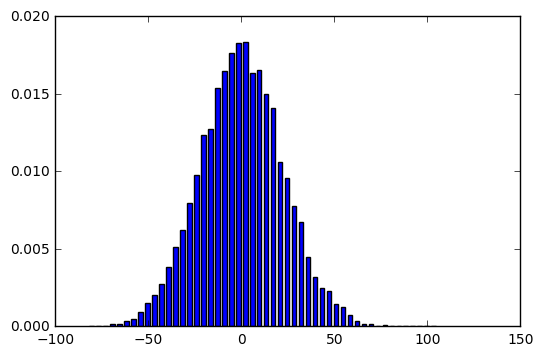

In [32]:
# simulate a weighted sum of 501 gaussian variables with mean 0 and std 1


# a single sum of 501 random gaussians, notice how large of a range we can get
s = np.sum(np.random.normal(loc=0.0, scale=1.0, size=(501,)))
print s

# simulate N of these sums at random and draw a histogram, in order to get a feel for the
# distribution of the values we are seeing
N = 10000
results = np.zeros(N)
for i in range(N):
    results[i] = np.sum(np.random.normal(loc=0.0, scale=1.0, size=(501,)))
    

# display/visualize as a histogram
hist, bins = np.histogram(results, 50, normed=True)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
''

In particular, we can see from this graph that it's quite likely that $|z|$ will be pretty large, i.e.,
either $z ≫ 1$ or $z ≪ −1$. If that's the case then the output $\sigma(z)$ from the hidden neuron will be
very close to either 1 or 0. That means our hidden neuron will have saturated. And when that happens, as we know,
making small changes in the weights will make only absolutely miniscule changes in the activation of our hidden
neuron. That miniscule change in the activation of the hidden neuron will, in turn, barely affect the rest of
the neurons in the network at all, and we'll see a correspondingly miniscule change in the cost function. As a
result, those weights will only learn very slowly when we use the gradient descent algorithm. It's similar to
the problem we discussed earlier in this chapter, in which output neurons which saturated on the wrong value
caused learning to slow down. We addressed that earlier problem with a clever choice of cost function.
Unfortunately, while that helped with saturated output neurons, it does nothing at all for the problem with
saturated hidden neurons.

I've been talking about the weights input to the first hidden layer. Of course, similar arguments apply also to
later hidden layers: if the weights in later hidden layers are initialized using normalized Gaussians, then
activations will often be very close to 0 or 1, and learning will proceed very slowly.

Is there some way we can choose better initializations for the weights and biases, so that we don't get this
kind of saturation, and so avoid a learning slowdown? Suppose we have a neuron with $n_{in}$ input weights.
Then we shall initialize those weights as Gaussian random variables with mean 0 and standard deviation
$1 / \sqrt{n_{in}}$. That is, we'll squash the Gaussians down, making it less likely that our neuron will saturate.
We'll continue to choose the bias as a Gaussian with mean 0 and standard deviation 1, for reasons I'll return to
in a moment. With these choices, the weighted sum $z = \sum_j w_j x_j + b$ will again be a Gaussian random
variable with mean 0, but it'll be much more sharply peaked than it was before. Suppose, as we did earlier,
that 500 of the inputs are zero and 500 are 1. Then it's easy to show that $z$ has a Gaussian distribution
with mean 0 and standard deviation $\sqrt{3 / 2} = 1.22...$. This is much more sharply peaked than before,
so much so that even the graph below understates the situation, since I've had to rescale the vertical
axis, when compared to the earlier graph:

0.04472135955
-0.681301271786


<Container object of 50 artists>

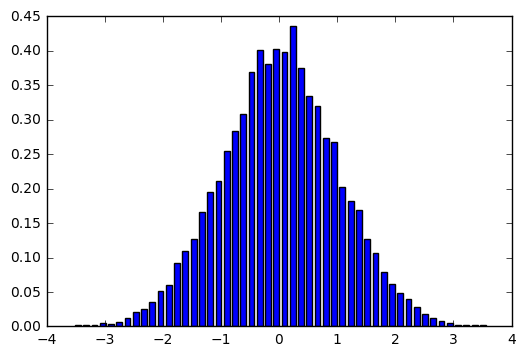

In [33]:
# simulate a weighted sum of 501 gaussian variables with mean 0 but a standard deviation of 1/sqrt(n_in)


# a single sum of 501 random gaussians, notice how large of a range we can get
sigma = 1.0 / np.sqrt(500)
print sigma
s = np.sum(np.random.normal(loc=0.0, scale=sigma, size=(501,)))
print s

# simulate N of these sums at random and draw a histogram, in order to get a feel for the
# distribution of the values we are seeing
N = 10000
results = np.zeros(N)
for i in range(N):
    results[i] = np.sum(np.random.normal(loc=0.0, scale=sigma, size=(501,)))
    

# display/visualize as a histogram
hist, bins = np.histogram(results, 50, normed=True)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)

Lets compare the results for both our old and new approaches to weight initialization, using the MNIST digit classificaiton task.
As before, we'll use 30 hidden neurons, a mini-batch size of 10, a regularization parameter $\lambda = 5.0$, and the 
cross-entropy cost function.  We will decrease the learning rate slightly from $\nu = 0.5$ to $0.1$, since that
makes the results a little more easily visible in the graphs.

We can train using the old method of weight initialization like this:

In [34]:
net = network2.Network([784, 30, 10], cost=network2.CrossEntropyCost)
net.large_weight_initializer()

eval_cost, eval_acc, train_cost, train_acc = \
    net.SGD(training_data, 30, 10, 0.1, 
            evaluation_data=validation_data, lmbda=5.0,
            monitor_training_cost=True, monitor_training_accuracy=True,
            monitor_evaluation_cost=True, monitor_evaluation_accuracy=True)


Epoch 0 training complete
Cost on training data: 2.04037568431
Accuracy on training data: 42431 / 50000
Cost on evaluation data: 6.30963525528
Accuracy on evaluation data: 8645 / 10000

Epoch 1 training complete
Cost on training data: 1.67943410179
Accuracy on training data: 44749 / 50000
Cost on evaluation data: 5.58170938549
Accuracy on evaluation data: 9024 / 10000

Epoch 2 training complete
Cost on training data: 1.47483729766
Accuracy on training data: 45658 / 50000
Cost on evaluation data: 5.03590550829
Accuracy on evaluation data: 9187 / 10000

Epoch 3 training complete
Cost on training data: 1.32818344295
Accuracy on training data: 46131 / 50000
Cost on evaluation data: 4.57885406831
Accuracy on evaluation data: 9276 / 10000

Epoch 4 training complete
Cost on training data: 1.21656488582
Accuracy on training data: 46468 / 50000
Cost on evaluation data: 4.18554090083
Accuracy on evaluation data: 9307 / 10000

Epoch 5 training complete
Cost on training data: 1.10384803241
Accurac

We can also train using the new approach to weight initialization.  This is actually even easier, since the default
behavior for `network2` code is to initialize weights based on this scaled approach.  

In [35]:
net = network2.Network([784, 30, 10], cost=network2.CrossEntropyCost)

eval_cost_new, eval_acc_new, train_cost_new, train_acc_new = \
    net.SGD(training_data, 30, 10, 0.1, 
            evaluation_data=validation_data, lmbda=5.0,
            monitor_training_cost=True, monitor_training_accuracy=True,
            monitor_evaluation_cost=True, monitor_evaluation_accuracy=True)

Epoch 0 training complete
Cost on training data: 0.554354661992
Accuracy on training data: 46194 / 50000
Cost on evaluation data: 0.650516373105
Accuracy on evaluation data: 9290 / 10000

Epoch 1 training complete
Cost on training data: 0.47258813762
Accuracy on training data: 46835 / 50000
Cost on evaluation data: 0.632604956562
Accuracy on evaluation data: 9392 / 10000

Epoch 2 training complete
Cost on training data: 0.43535484533
Accuracy on training data: 47158 / 50000
Cost on evaluation data: 0.643502856765
Accuracy on evaluation data: 9433 / 10000

Epoch 3 training complete
Cost on training data: 0.417226060194
Accuracy on training data: 47429 / 50000
Cost on evaluation data: 0.65335436791
Accuracy on evaluation data: 9510 / 10000

Epoch 4 training complete
Cost on training data: 0.400405524618
Accuracy on training data: 47663 / 50000
Cost on evaluation data: 0.667625229556
Accuracy on evaluation data: 9506 / 10000

Epoch 5 training complete
Cost on training data: 0.376072129928

Plotting the results we obtain:

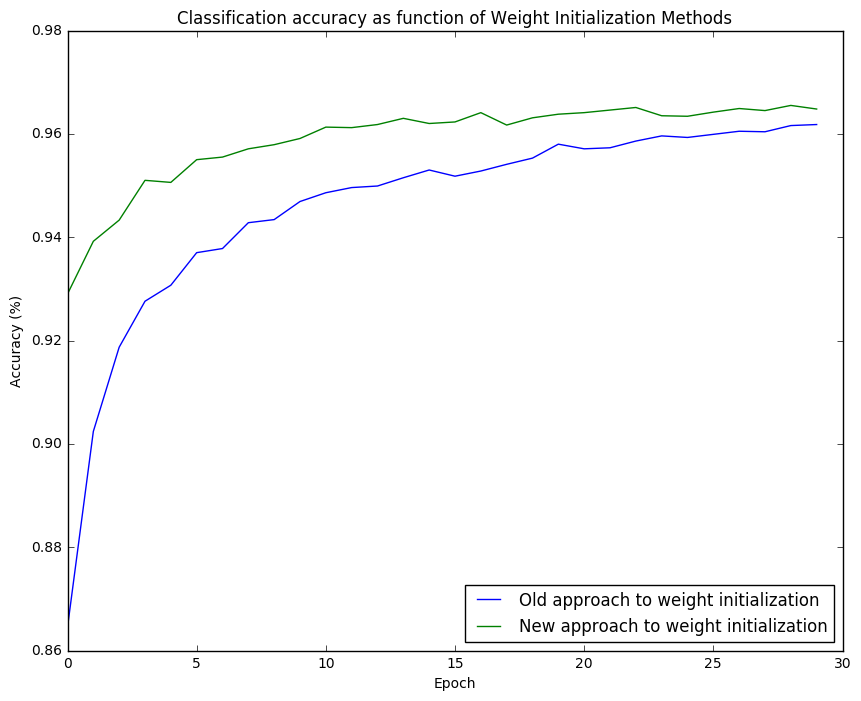

In [36]:
old_accuracy_pct = [correct / 10000.0 for correct in eval_acc]
new_accuracy_pct = [correct / 10000.0 for correct in eval_acc_new]

plt.figure(figsize=(10,8))
epochs = np.arange(0, 30)
plt.plot(epochs, old_accuracy_pct, label='Old approach to weight initialization')
plt.plot(epochs, new_accuracy_pct, label='New approach to weight initialization')
plt.xlabel('Epoch')
plt.legend(loc=4)
plt.ylabel('Accuracy (%)')
plt.title('Classification accuracy as function of Weight Initialization Methods')